### Amazon Product Review Helpfulness Kaggle competetion 

##### Amazon is a leading e-commerce website and uses Machine Learning applications extensively in their products. For example, they recommend products based on your browsing history and previous purchases so as to maximize their profit (by selling you another product!). Given Amazon review data - the item for which the review is and the user who has written the review, need to predict how helpful the review will be.


In [1]:
import gzip
from collections import defaultdict

In [2]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from collections import Counter 

from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib as mpl
%matplotlib inline

### Compute the global average helpfulness rate, and the average helpfulness rate for each user

In [3]:
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

allHelpful = []
userHelpful = defaultdict(list)

for l in readGz("train.json.gz"):
  user,item = l['reviewerID'],l['itemID']
  allHelpful.append(l['helpful'])
  userHelpful[user].append(l['helpful'])

averageRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
userRate = {}
for u in userHelpful:
  totalU = sum([x['outOf'] for x in userHelpful[u]])
  if totalU > 0:
    userRate[u] = sum([x['nHelpful'] for x in userHelpful[u]]) * 1.0 / totalU
  else:
    userRate[u] = averageRate

## For reading the files in a pandas Dataframe.

In [4]:
import pandas as pd
from collections import defaultdict

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

In [52]:
train_data = df.copy()
train_data.drop(['categoryID','reviewHash', 'reviewTime', 'unixReviewTime'], axis=1, inplace=True)

In [53]:
train_data['len_summary'] = train_data['summary'].str.len()
train_data['len_reviewText'] = train_data['reviewText'].str.len()
train_data['ratio_reviewOverSummary'] = train_data['len_reviewText']/train_data['len_summary']

In [54]:
train_data['outOf'] = train_data['helpful'].apply(lambda x: x['outOf'])
train_data['nHelpful'] = train_data['helpful'].apply(lambda x: x['nHelpful'])
train_data = train_data[train_data.outOf != 0]

train_data['ratio_nHelpful']=train_data['nHelpful']/train_data['outOf']

In [55]:
train_data['nSentence_Clause'] = train_data['reviewText'].apply(lambda x: (Counter(x)['.'] + Counter(x) [';'] \
                                                                           + Counter(x) [','] ) )
train_data['UR']= train_data['reviewerID'].map(userRate)

outOf_max = train_data['outOf'].max() 
train_data['wt_outOf'] = 100 * (train_data['outOf']/outOf_max)

train_data['wt_UR'] = train_data['UR'] * train_data['wt_outOf']

In [56]:
train_data['len_categories'] = train_data['categories'].apply(lambda x: len(x ))

In [57]:
train_data.drop(['categories', 'reviewText', 'price','summary', 'helpful','nHelpful' ], axis=1, inplace=True)

In [58]:
#AL -testing with minimal features
train_data.drop(['len_categories', 'wt_outOf', 'len_summary','UR','wt_UR'], axis=1, inplace=True)
train_data.head(3)

,itemID,reviewerID,rating,len_reviewText,ratio_reviewOverSummary,outOf,ratio_nHelpful,nSentence_Clause
2,I408260822,U441384838,3.0,144,8.470588,2,1.0,3
4,I919238161,U096604734,5.0,424,38.545455,1,1.0,7
5,I098334555,U481392145,4.0,466,19.416667,1,1.0,7


In [61]:
# len(train_data[train_data.outOf == 1])
# len(train_data[train_data.outOf > 400])

# These outliars data points can be dropped. 
# For OutOf equal to i cases we can use classificaiton (instead of regression)

In [62]:
test_data = test_df.copy()
test_data.drop(['categoryID','reviewHash', 'reviewTime', 'unixReviewTime'], axis=1, inplace=True)

test_data['len_summary'] = test_data['summary'].str.len()
test_data['len_reviewText'] = test_data['reviewText'].str.len()
test_data['ratio_reviewOverSummary'] = test_data['len_reviewText']/test_data['len_summary']

test_data['outOf'] = test_data['helpful'].apply(lambda x: x['outOf'])
test_data = test_data[test_data.outOf != 0]

test_data['nSentence_Clause'] = test_data['reviewText'].apply(lambda x: (Counter(x)['.'] + Counter(x) [';'] \
                                                                           + Counter(x) [','] ) )
test_data['UR']= test_data['reviewerID'].map(userRate)
test_data['UR'].fillna(averageRate, inplace=True)

outOf_max_test = test_data['outOf'].max() 
test_data['wt_outOf'] = 100 * (test_data['outOf']/outOf_max_test)
test_data['wt_UR'] = test_data['UR'] * test_data['wt_outOf']

test_data['len_categories'] = test_data['categories'].apply(lambda x: len(x ))


In [63]:
test_data.drop(['categories', 'reviewText', 'price','summary','helpful'], axis=1, inplace=True)

In [ ]:
#AL -testing with minimal features
test_data.drop(['len_categories', 'wt_outOf', 'len_summary','UR','wt_UR' ], axis=1, inplace=True)

In [66]:
X_train = train_data.drop(['itemID','reviewerID', 'ratio_nHelpful'], axis=1)
y_train = train_data['ratio_nHelpful']

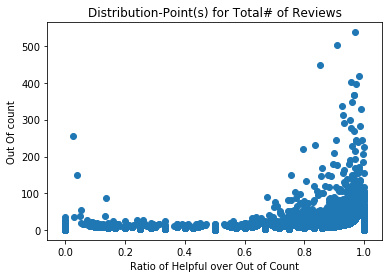

In [79]:
y = train_data['outOf'].values
x = train_data['ratio_nHelpful'].values

plt.xlabel('Ratio of Helpful over Out of Count')
plt.ylabel('Out Of count')
plt.title("Distribution-Point(s) for Total# of Reviews")
plt.scatter(x,y);

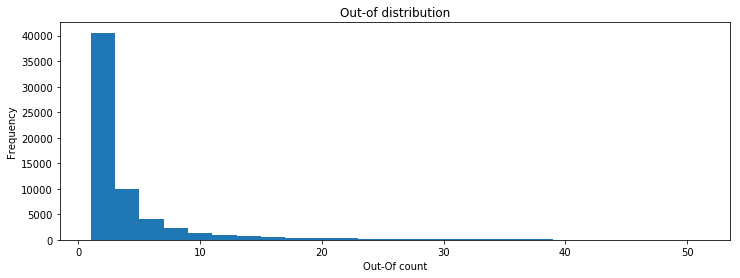

In [100]:
binwidth = 2
plt.figure(figsize=(12,4))
bins1 =range(train_data['outOf'].min(), 50 + binwidth, binwidth)
plt.title("Out-of distribution")
plt.ylabel('Frequency')
plt.xlabel('Out-Of count')
plt.hist(train_data['outOf'].values, bins=bins1);

In [101]:
print ("Shape of X_train", len(X_train))
print ("Shape of y_train ", len(y_train))
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train,\
                                                        test_size=0.2, random_state=10)
print ("Shape of X_train_split, X_valid : ", len(X_train_split), len(X_valid))
print ("Shape of y_train_split, , y_valid: ", len(y_train_split), len(y_valid))

Shape of X_train 63016
Shape of y_train  63016
Shape of X_train_split, X_valid :  50412 12604
Shape of y_train_split, , y_valid:  50412 12604


In [102]:
X_train_split = X_train_split[X_train_split.outOf != 0]
X_train_split.shape

(50412, 5)

In [ ]:
#n_estimators': range(50,250,50)
# parameters = {'n_estimators': [40, 60, 80, 100, 150, 200], 'max_depth': [4, 8, 12], \
#                     'learning_rate':[0.05, 0.1, 0.2], 'loss': ['ls', 'lad']}
                                                                           
# # params = {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'loss': 'ls'}
# #clf = ensemble.GradientBoostingRegressor(**params)

# GBR = ensemble.GradientBoostingRegressor()
# clf = GridSearchCV(GBR, parameters, verbose=False, n_jobs=-1)

# clf.fit(X_train_split, y_train_split)
# predictions = clf.predict(X_valid)

# mse = mean_squared_error(y_valid, predictions)
# mae = mean_absolute_error(y_valid, predictions)
# print("MSE: %.4f" % mse)
# print("MAE: %.4f" % mae)

In [107]:
params = {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [28]:
predictions = open("predictions_Helpful.txt", 'w')

for l in open("pairs_Helpful.txt"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,i,outOf = l.strip().split('-')
    outOf = int(outOf)
    
    if outOf == 0:
        predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(outOf) + '\n')
    else:
        temp_X = (test_data.loc[(test_data['itemID'] == i) & (test_data['reviewerID'] == u)] ) \
                                                                .drop(['itemID','reviewerID'], axis=1)
        pred_value = round(clf.predict(temp_X)[0], 3)
        predictions.write(u + '-' + i + '-' + str(outOf) + ',' + str(round(outOf * pred_value) ) + '\n')

predictions.close()

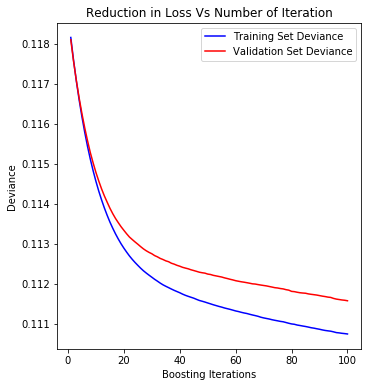

In [136]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_valid)):
    test_score[i] = clf.loss_(y_valid, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Reduction in Loss Vs Number of Iteration')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance');

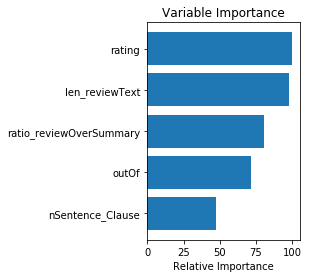

In [109]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()